In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
import seaborn as sns
%matplotlib inline
#from connection_ms_sql import CreateDatabaseTable as cdt
#from read_csv_save_data_ms_sql import ReadCsv as rcsv
#from calculation import Calculations as cal
#from ploting import Plot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import metrics
import sklearn.tree as tree

This dataset is about the performance of basketball teams. The __cbb.csv__ data set includes performance data about five seasons of 354 basketball teams. It includes the following fields:

| Field          | Description                                                                           |
|----------------|---------------------------------------------------------------------------------------|
|TEAM |	The Division I college basketball school|
|CONF|	The Athletic Conference in which the school participates in (A10 = Atlantic 10, ACC = Atlantic Coast Conference, AE = America East, Amer = American, ASun = ASUN, B10 = Big Ten, B12 = Big 12, BE = Big East, BSky = Big Sky, BSth = Big South, BW = Big West, CAA = Colonial Athletic Association, CUSA = Conference USA, Horz = Horizon League, Ivy = Ivy League, MAAC = Metro Atlantic Athletic Conference, MAC = Mid-American Conference, MEAC = Mid-Eastern Athletic Conference, MVC = Missouri Valley Conference, MWC = Mountain West, NEC = Northeast Conference, OVC = Ohio Valley Conference, P12 = Pac-12, Pat = Patriot League, SB = Sun Belt, SC = Southern Conference, SEC = South Eastern Conference, Slnd = Southland Conference, Sum = Summit League, SWAC = Southwestern Athletic Conference, WAC = Western Athletic Conference, WCC = West Coast Conference)|
|G|	Number of games played|
|W|	Number of games won|
|ADJOE|	Adjusted Offensive Efficiency (An estimate of the offensive efficiency (points scored per 100 possessions) a team would have against the average Division I defense)|
|ADJDE|	Adjusted Defensive Efficiency (An estimate of the defensive efficiency (points allowed per 100 possessions) a team would have against the average Division I offense)|
|BARTHAG|	Power Rating (Chance of beating an average Division I team)|
|EFG_O|	Effective Field Goal Percentage Shot|
|EFG_D|	Effective Field Goal Percentage Allowed|
|TOR|	Turnover Percentage Allowed (Turnover Rate)|
|TORD|	Turnover Percentage Committed (Steal Rate)|
|ORB|	Offensive Rebound Percentage|
|DRB|	Defensive Rebound Percentage|
|FTR|	Free Throw Rate (How often the given team shoots Free Throws)|
|FTRD|	Free Throw Rate Allowed|
|2P_O|	Two-Point Shooting Percentage|
|2P_D|	Two-Point Shooting Percentage Allowed|
|3P_O|	Three-Point Shooting Percentage|
|3P_D|	Three-Point Shooting Percentage Allowed|
|ADJ_T|	Adjusted Tempo (An estimate of the tempo (possessions per 40 minutes) a team would have against the team that wants to play at an average Division I tempo)|
|WAB|	Wins Above Bubble (The bubble refers to the cut off between making the NCAA March Madness Tournament and not making it)|
|POSTSEASON|	Round where the given team was eliminated or where their season ended (R68 = First Four, R64 = Round of 64, R32 = Round of 32, S16 = Sweet Sixteen, E8 = Elite Eight, F4 = Final Four, 2ND = Runner-up, Champion = Winner of the NCAA March Madness Tournament for that given year)|
|SEED|	Seed in the NCAA March Madness Tournament|
|YEAR|	Season


In [2]:
# Load basketball team performance data
team_stats = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-ML0101EN-SkillsNetwork/labs/Module%206/cbb.csv')
team_stats.head()

# Introduce a new column 'elite_status' indicating if teams are significantly above the tournament bubble threshold
team_stats['elite_status'] = np.where(team_stats['WAB'] > 7, 'Above', 'Below')

# Narrow down the dataset to include only teams that reached the later stages of the postseason
postseason_teams = team_stats[team_stats['POSTSEASON'].isin(['F4', 'S16', 'E8'])]
postseason_teams.head()

# Display the distribution of teams across selected postseason stages
team_distribution = postseason_teams['POSTSEASON'].value_counts()
print(team_distribution)


POSTSEASON
S16    32
E8     16
F4      8
Name: count, dtype: int64


Plot the BARTHING(Chance of a team to beat another team in post Season more like Power Rating of the Team)

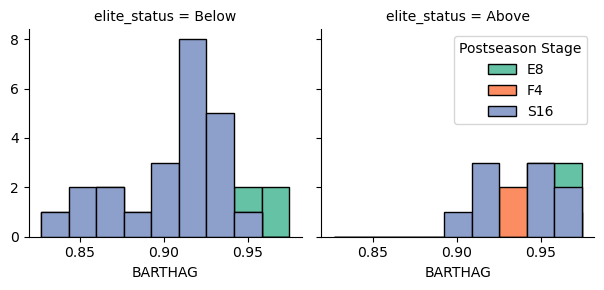

In [3]:
# Define the range for histogram bins based on the Power Rating (BARTHAG) distribution
rating_bins = np.linspace(postseason_teams.BARTHAG.min(), postseason_teams.BARTHAG.max(), 10)

# Create a FacetGrid to visualize the distribution of Power Ratings across different postseason stages, segmented by elite status
power_rating_grid = sns.FacetGrid(postseason_teams, col="elite_status", hue="POSTSEASON", palette="Set2", col_wrap=4)
power_rating_grid.map(plt.hist, 'BARTHAG', bins=rating_bins, edgecolor="black")

# Add a legend to the last plot and display the grid
power_rating_grid.axes[-1].legend(title='Postseason Stage')
plt.show()


Plot the ADJOE (Adjusted Offensive Efficiency) of Each Team

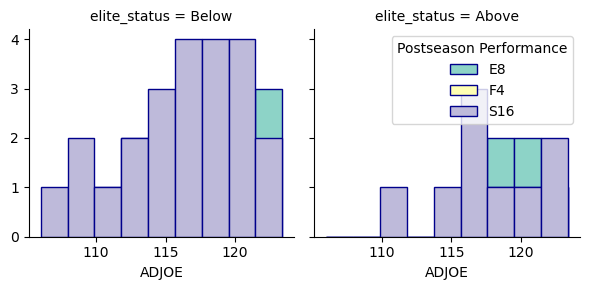

In [4]:
# Establish histogram bins for Adjusted Offensive Efficiency (ADJOE) across the dataset
efficiency_bins = np.linspace(postseason_teams.ADJOE.min(), postseason_teams.ADJOE.max(), 10)

# Configure a FacetGrid to display ADJOE distributions by elite status, colored by postseason performance
offensive_efficiency_grid = sns.FacetGrid(postseason_teams, col="elite_status", hue="POSTSEASON", palette="Set3", col_wrap=2)
offensive_efficiency_grid.map(plt.hist, 'ADJOE', bins=efficiency_bins, edgecolor="darkblue")

# Add a legend with a title to the grid and display the plot
offensive_efficiency_grid.axes[-1].legend(title='Postseason Performance')
plt.show()


Plot ADJDC (Adjusted Defence Efficency) of each team

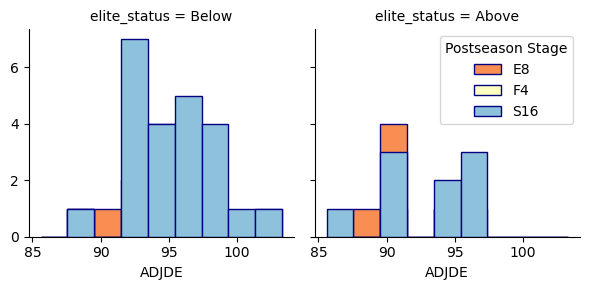

In [5]:
# Determine histogram bins based on the range of Adjusted Defensive Efficiency (ADJDE)
defense_bins = np.linspace(postseason_teams.ADJDE.min(), postseason_teams.ADJDE.max(), 10)

# Set up a FacetGrid for visualizing ADJDE distribution, categorized by elite status and postseason results
defensive_efficiency_grid = sns.FacetGrid(postseason_teams, col="elite_status", hue="POSTSEASON", palette="RdYlBu", col_wrap=2)
defensive_efficiency_grid.map(plt.hist, 'ADJDE', bins=defense_bins, edgecolor="navy")

# Incorporate a legend to the grid for interpretability and display the visualization
defensive_efficiency_grid.axes[-1].legend(title="Postseason Stage")
plt.show()


In [6]:
# Analyzing distribution of postseason achievements relative to elite status
postseason_performance = postseason_teams.groupby(['elite_status'])['POSTSEASON'].value_counts(normalize=True)
print(postseason_performance)

# Updating 'elite_status' column: 0 for teams below bubble threshold, 1 for teams above
postseason_teams['elite_status_numeric'] = postseason_teams['elite_status'].map({'Below': 0, 'Above': 1})
print(postseason_teams.head())

# Preparing feature set 'feature_matrix' and target variable 'target_vector'
feature_matrix = postseason_teams[['G', 'W', 'ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D',
                                   'TOR', 'TORD', 'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', 
                                   '3P_O', '3P_D', 'ADJ_T', 'WAB', 'SEED', 'elite_status_numeric']]
print(feature_matrix.head())

# Overview of postseason stages
target_vector = postseason_teams['POSTSEASON'].values
print(target_vector[:5])

# Standardizing feature_matrix to have zero mean and unit variance
scaler = preprocessing.StandardScaler()
feature_matrix_standardized = scaler.fit_transform(feature_matrix)
print(feature_matrix_standardized[:5])

# Splitting the standardized features and target into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(feature_matrix_standardized, target_vector, test_size=0.2, random_state=4)
print('Training set dimensions:', X_train.shape, y_train.shape)
print('Validation set dimensions:', X_val.shape, y_val.shape)


elite_status  POSTSEASON
Above         S16           0.500000
              E8            0.333333
              F4            0.166667
Below         S16           0.605263
              E8            0.263158
              F4            0.131579
Name: proportion, dtype: float64
         TEAM CONF   G   W  ADJOE  ADJDE  BARTHAG  EFG_O  EFG_D   TOR  ...  \
2  Notre Dame  ACC  36  24  118.3  103.3   0.8269   54.0   49.5  15.3  ...   
3    Virginia  ACC  37  29  119.9   91.0   0.9600   54.8   48.4  15.1  ...   
4      Kansas  B12  37  32  120.9   90.4   0.9662   55.7   45.1  17.8  ...   
5      Oregon  P12  37  30  118.4   96.2   0.9163   52.3   48.9  16.1  ...   
6    Syracuse  ACC  37  23  111.9   93.6   0.8857   50.0   47.3  18.1  ...   

   2P_D  3P_O  3P_D  ADJ_T   WAB  POSTSEASON  SEED  YEAR  elite_status  \
2  46.5  37.4  36.9   65.5   2.3          E8   6.0  2016         Below   
3  46.3  40.3  34.7   61.9   8.6          E8   1.0  2016         Above   
4  43.4  41.3  32.5   70.1  1

C:\Users\nasir\AppData\Local\Temp\ipykernel_24164\1686497888.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  postseason_teams['elite_status_numeric'] = postseason_teams['elite_status'].map({'Below': 0, 'Above': 1})


Find the best value of 'K' of KNN Algorithem using Train Data set and Visualize

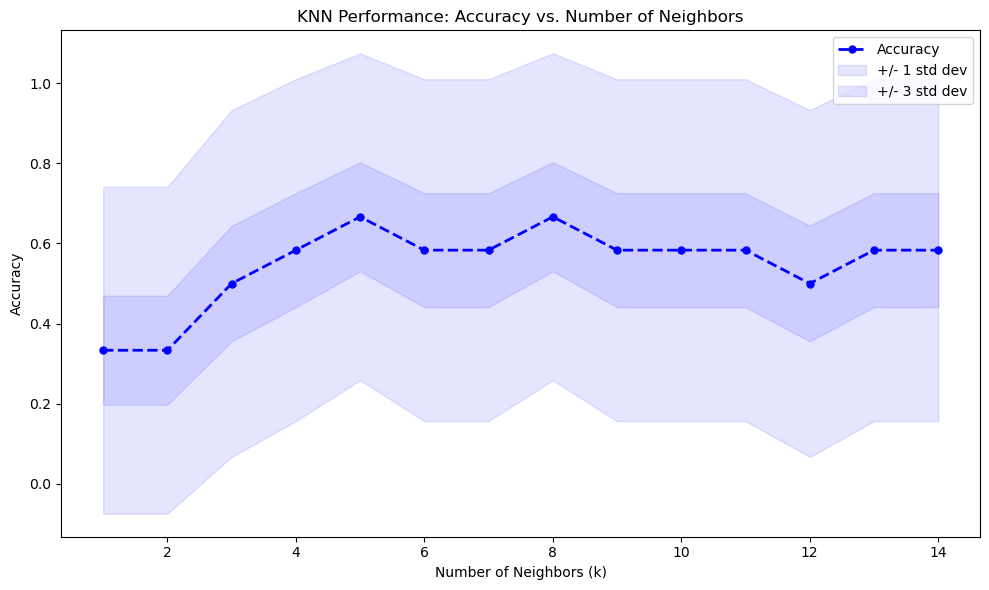

The highest model accuracy was 0.6667 with k=5


In [7]:
num_neighbors = 15
accuracy_scores = np.zeros((num_neighbors-1))
accuracy_std_dev = np.zeros((num_neighbors-1))

for k in range(1, num_neighbors):
    # Initialize and train the KNN model for each k
    knn_model = KNeighborsClassifier(n_neighbors=k).fit(X_train, y_train)
    predictions = knn_model.predict(X_val)
    
    # Calculate accuracy and standard deviation of accuracy
    accuracy_scores[k-1] = metrics.accuracy_score(y_val, predictions)
    accuracy_std_dev[k-1] = np.std(predictions == y_val) / np.sqrt(predictions.shape[0])

# Visualizing the accuracy of different k values
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_neighbors), accuracy_scores, color='blue', marker='o', linestyle='dashed', linewidth=2, markersize=5)
plt.fill_between(range(1, num_neighbors), accuracy_scores - 1 * accuracy_std_dev, accuracy_scores + 1 * accuracy_std_dev, alpha=0.1, color="blue")
plt.fill_between(range(1, num_neighbors), accuracy_scores - 3 * accuracy_std_dev, accuracy_scores + 3 * accuracy_std_dev, alpha=0.1, color="blue", label='+/- 3 std dev')

plt.legend(['Accuracy', '+/- 1 std dev', '+/- 3 std dev'])
plt.title('KNN Performance: Accuracy vs. Number of Neighbors')
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.tight_layout()
plt.show()

# Determine and print the optimal number of neighbors
optimal_k = accuracy_scores.argmax() + 1
print(f"The highest model accuracy was {accuracy_scores.max():.4f} with k={optimal_k}")


Find the best value for 'max_depth' for Decision Tree algorithem Using train dataset

Depth 1: Accuracy = 0.6667
Depth 2: Accuracy = 0.6667
Depth 3: Accuracy = 0.5000
Depth 4: Accuracy = 0.3333
Depth 5: Accuracy = 0.4167
Depth 6: Accuracy = 0.5000
Depth 7: Accuracy = 0.5000
Depth 8: Accuracy = 0.4167
Depth 9: Accuracy = 0.5000
Depth 10: Accuracy = 0.4167
Depth 11: Accuracy = 0.5000
Depth 12: Accuracy = 0.5000
Depth 13: Accuracy = 0.5000
Depth 14: Accuracy = 0.5000

Optimal Tree Depth: 1 with Highest Accuracy: 0.6667


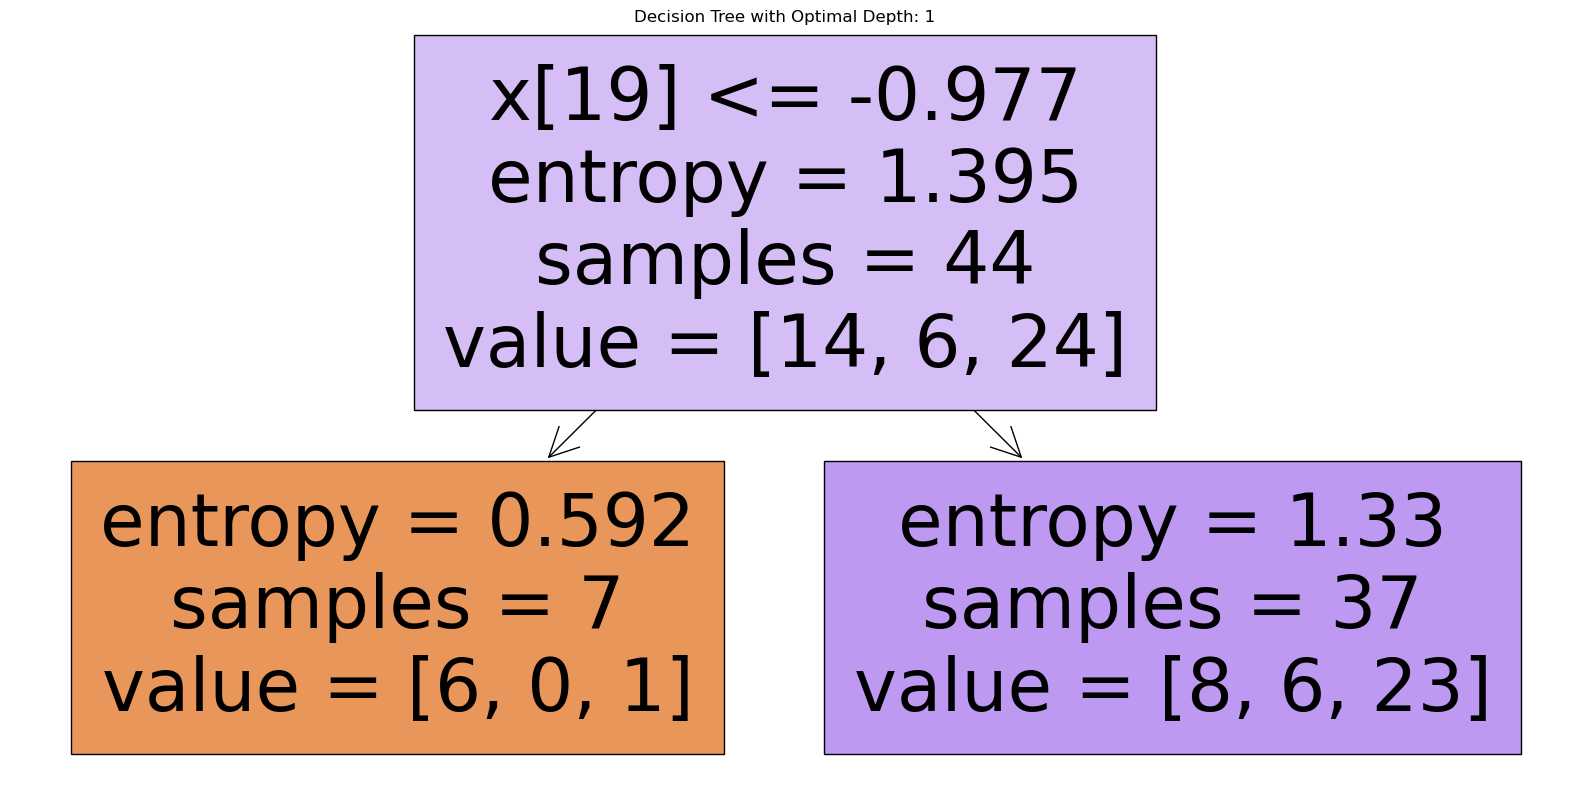

In [8]:
optimal_depth_range = 15
depth_accuracy_mapping = {}

for depth in range(1, optimal_depth_range):
    # Initialize and train Decision Tree model with varying depth
    decision_model = DecisionTreeClassifier(criterion="entropy", max_depth=depth)
    decision_model.fit(X_train, y_train)

    # Make predictions and calculate accuracy for the current depth
    predictions_decision = decision_model.predict(X_val)
    current_accuracy = metrics.accuracy_score(y_val, predictions_decision)
    depth_accuracy_mapping[depth] = current_accuracy

# Display the accuracy for each tree depth
for depth, accuracy in depth_accuracy_mapping.items():
    print(f"Depth {depth}: Accuracy = {accuracy:.4f}")

# Identify and print the depth with the highest accuracy
optimal_depth, highest_accuracy = max(depth_accuracy_mapping.items(), key=lambda x: x[1])
print(f"\nOptimal Tree Depth: {optimal_depth} with Highest Accuracy: {highest_accuracy:.4f}")

# Visualize the Decision Tree with the optimal depth
plt.figure(figsize=(20,10))
optimal_tree_visual = DecisionTreeClassifier(criterion="entropy", max_depth=optimal_depth)
optimal_tree_visual.fit(X_train, y_train)
tree.plot_tree(optimal_tree_visual, filled=True)
plt.title(f"Decision Tree with Optimal Depth: {optimal_depth}")
plt.show()


Model Evatuation Using Test Data SET

In [9]:
from sklearn.metrics import f1_score, log_loss

def calculate_jaccard_similarity(predictions, actual):
    """
    Calculate the Jaccard similarity index between two lists of predictions and actual values.
    Jaccard similarity is defined as the size of the intersection divided by the size of the union of two label sets.
    
    Parameters:
    - predictions: a list of predicted labels
    - actual: a list of actual labels
    
    Returns:
    - The Jaccard similarity index if inputs are valid, otherwise -1.
    """
    if len(predictions) == len(actual):
        intersection_count = sum(1 for pred, act in zip(predictions, actual) if pred == act)
        union_count = len(predictions) + len(actual) - intersection_count
        return intersection_count / union_count if union_count != 0 else 0
    else:
        return -1


In [23]:
# Loading the test dataset for evaluation
test_data = pd.read_csv('https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0120ENv3/Dataset/ML0101EN_EDX_skill_up/basketball_train.csv')
print(test_data.head())

# Adding a 'performance_indicator' column based on Wins Above Bubble
test_data['performance_indicator'] = np.where(test_data['WAB'] > 7, 'High Performance', 'Low Performance')

# Filtering the test dataset for teams that reached advanced stages in the postseason
filtered_test_data = test_data[test_data['POSTSEASON'].isin(['F4', 'S16', 'E8'])]
test_features = filtered_test_data[['G', 'W', 'ADJOE', 'ADJDE', 'BARTHAG', 'EFG_O', 'EFG_D',
                                    'TOR', 'TORD', 'ORB', 'DRB', 'FTR', 'FTRD', '2P_O', '2P_D', 
                                    '3P_O', '3P_D', 'ADJ_T', 'WAB', 'SEED', 'performance_indicator']]

test_features['performance_indicator'] = test_features['performance_indicator'].map({'Low Performance': 0, 'High Performance': 1})

# Standardizing the features for the test set
standardized_test_features = preprocessing.StandardScaler().fit_transform(test_features)
print(standardized_test_features[:5])

# Extracting the target values for the test set
target_test_values = filtered_test_data['POSTSEASON'].values
print(target_test_values[:5])

# Initializing lists to store results of model evaluations
models_evaluated = []
kernels_evaluated = []
model_accuracy = []
jaccard_scores = []
f1_scores = []
log_loss_scores = []


             TEAM CONF   G   W  ADJOE  ADJDE  BARTHAG  EFG_O  EFG_D   TOR  \
0  North Carolina  ACC  40  33  123.3   94.9   0.9531   52.6   48.1  15.4   
1       Villanova   BE  40  35  123.1   90.9   0.9703   56.1   46.7  16.3   
2      Notre Dame  ACC  36  24  118.3  103.3   0.8269   54.0   49.5  15.3   
3        Virginia  ACC  37  29  119.9   91.0   0.9600   54.8   48.4  15.1   
4          Kansas  B12  37  32  120.9   90.4   0.9662   55.7   45.1  17.8   

   ...  FTRD  2P_O  2P_D  3P_O  3P_D  ADJ_T   WAB  POSTSEASON  SEED  YEAR  
0  ...  30.4  53.9  44.6  32.7  36.2   71.7   8.6         2ND   1.0  2016  
1  ...  30.0  57.4  44.1  36.2  33.9   66.7   8.9   Champions   2.0  2016  
2  ...  26.0  52.9  46.5  37.4  36.9   65.5   2.3          E8   6.0  2016  
3  ...  33.4  52.6  46.3  40.3  34.7   61.9   8.6          E8   1.0  2016  
4  ...  37.3  52.7  43.4  41.3  32.5   70.1  11.6          E8   1.0  2016  

[5 rows x 24 columns]
[[-4.08074446e-01 -1.10135297e+00  3.37365934e-01  2.66479

C:\Users\nasir\AppData\Local\Temp\ipykernel_24164\542682134.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_features['performance_indicator'] = test_features['performance_indicator'].map({'Low Performance': 0, 'High Performance': 1})


TEST ALL Algorithems on Test data

KNN (K-Nearest Neighbour)

In [18]:
from sklearn.metrics import accuracy_score, f1_score, jaccard_score

# Using the optimal number of neighbors determined earlier for KNN model training and prediction
optimal_k_neighbors = optimal_k
knn_classifier = KNeighborsClassifier(n_neighbors=optimal_k_neighbors).fit(X_train, y_train)

# Generating predictions for the test set
predictions_knn = knn_classifier.predict(standardized_test_features)
print(predictions_knn[:5])

# Evaluating the model's performance on the test set
test_accuracy_knn = accuracy_score(target_test_values, predictions_knn)
f1_score_knn = f1_score(target_test_values, predictions_knn, average='micro')
jaccard_score_knn = jaccard_score(target_test_values, predictions_knn, average='micro')  # Adjust pos_label as per your data

# Displaying the evaluation metrics
print(f"KNN Test Set Accuracy: {test_accuracy_knn}")
print(f"KNN F1 Score: {f1_score_knn}")
print(f"KNN Jaccard Score: {jaccard_score_knn}")

# Appending results to the evaluation lists
models_evaluated.append('KNN')
kernels_evaluated.append('Not Applicable')  # KNN does not use a kernel
model_accuracy.append(test_accuracy_knn)
jaccard_scores.append(jaccard_score_knn)
f1_scores.append(f1_score_knn)
log_loss_scores.append('Not Applicable')  # Log loss is not applicable to KNN in this context


['S16' 'S16' 'E8' 'E8' 'E8']
KNN Test Set Accuracy: 0.6285714285714286
KNN F1 Score: 0.6285714285714286
KNN Jaccard Score: 0.4583333333333333


Desision TREE Algorithem

In [19]:
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, jaccard_score

# Utilize the optimal depth found from previous analysis for the Decision Tree
optimal_tree_depth = optimal_depth

# Initialize and train the Decision Tree classifier
decision_tree_model = DecisionTreeClassifier(criterion="entropy", max_depth=optimal_tree_depth)
decision_tree_model.fit(X_train, y_train)

# Generate predictions on the test dataset
predictions_dt = decision_tree_model.predict(standardized_test_features)
test_accuracy_dt = accuracy_score(target_test_values, predictions_dt)

# Evaluate and display the model's performance
print(f"Decision Tree Test Set Accuracy: {test_accuracy_dt}")

# Calculate additional performance metrics
f1_score_dt = f1_score(target_test_values, predictions_dt, average='micro')
jaccard_score_dt = jaccard_score(target_test_values, predictions_dt, average='micro')  # Adjust pos_label as needed

print(f"Decision Tree F1 Score: {f1_score_dt}")
print(f"Decision Tree Jaccard Score: {jaccard_score_dt}")

# Appending the model's performance metrics to the results lists
models_evaluated.append('Decision Tree')
kernels_evaluated.append('Not Applicable')  # Decision Trees do not use a kernel
model_accuracy.append(test_accuracy_dt)
jaccard_scores.append(jaccard_score_dt)
f1_scores.append(f1_score_dt)
log_loss_scores.append('Not Applicable')  # Log loss is not applicable to Decision Tree in this context


Decision Tree Test Set Accuracy: 0.6428571428571429
Decision Tree F1 Score: 0.6428571428571429
Decision Tree Jaccard Score: 0.47368421052631576


SVM

In [24]:
from sklearn import svm
from sklearn.metrics import accuracy_score, f1_score, jaccard_score

# Define the kernel types to be evaluated with the SVM model
kernel_types = ['linear', 'poly', 'rbf', 'sigmoid']

for kernel in kernel_types:
    # Initialize and train the SVM model with each kernel type
    svm_classifier = svm.SVC(kernel=kernel)
    svm_classifier.fit(X_train, y_train)

    # Generate predictions for the test dataset using the trained SVM model
    predictions_svm = svm_classifier.predict(standardized_test_features)

    # Evaluate the model's performance and print the results
    test_accuracy_svm = accuracy_score(target_test_values, predictions_svm)
    f1_score_svm = f1_score(target_test_values, predictions_svm, average='micro')
    jaccard_score_svm = jaccard_score(target_test_values, predictions_svm, average='micro')

    print(f'Kernel="{kernel}" | Accuracy: {test_accuracy_svm:.4f} | F1 Score: {f1_score_svm:.4f} | Jaccard Score: {jaccard_score_svm:.4f}')

    # Store the model evaluation metrics in the results lists
    models_evaluated.append('SVM')
    kernels_evaluated.append(kernel)
    model_accuracy.append(test_accuracy_svm)
    jaccard_scores.append(jaccard_score_svm)
    f1_scores.append(f1_score_svm)
    log_loss_scores.append('Not Applicable')  # Log loss is not applicable here


Kernel="linear" | Accuracy: 0.7714 | F1 Score: 0.7714 | Jaccard Score: 0.6279
Kernel="poly" | Accuracy: 0.6857 | F1 Score: 0.6857 | Jaccard Score: 0.5217
Kernel="rbf" | Accuracy: 0.7429 | F1 Score: 0.7429 | Jaccard Score: 0.5909
Kernel="sigmoid" | Accuracy: 0.6000 | F1 Score: 0.6000 | Jaccard Score: 0.4286


Logistic Regrssion

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, log_loss

# Initialize and train the Logistic Regression model
logistic_model = LogisticRegression(C=0.01, solver='liblinear').fit(X_train, y_train)

# Predict outcomes for the test dataset
predictions_lr = logistic_model.predict(standardized_test_features)

# Predict probability outcomes for calculating log loss
predictions_proba_lr = logistic_model.predict_proba(standardized_test_features)

# Calculate performance metrics
accuracy_lr = accuracy_score(target_test_values, predictions_lr)
f1_score_lr = f1_score(target_test_values, predictions_lr, average='micro')
jaccard_score_lr = jaccard_score(target_test_values, predictions_lr, average='micro')  # Adjust pos_label as needed
log_loss_lr = log_loss(target_test_values, predictions_proba_lr)

# Print the performance metrics
print(f"Logistic Regression Accuracy: {accuracy_lr:.4f} | F1 Score: {f1_score_lr:.4f} | Log Loss: {log_loss_lr:.4f} | Jaccard Score: {jaccard_score_lr:.4f}")

# Store the evaluation metrics for Logistic Regression in the results lists
models_evaluated.append('Logistic Regression')
kernels_evaluated.append('Not Applicable')  # Indicating Logistic Regression does not use kernel methods
model_accuracy.append(accuracy_lr)
jaccard_scores.append(jaccard_score_lr)
f1_scores.append(f1_score_lr)
log_loss_scores.append(log_loss_lr)


Logistic Regression Accuracy: 0.6571 | F1 Score: 0.6571 | Log Loss: 1.0264 | Jaccard Score: 0.4894


In [21]:
from sqlalchemy import create_engine

def sql(results):
    server = 'NASIR'  # e.g., 'localhost\SQLEXPRESS' or an IP address
    database_name = 'Assignment'  # Connect to the database to create another database
    username = 'nasir'  # SQL Server username, omit if using Windows authentication
    password = 'Cheema01'  # SQL Server password, omit if using Windows authentication
    driver  = 'ODBC Driver 17 for SQL Server' #driver used to connect with MS SQL Server 2022
    table_name = 'Results'   #copy the results to results table in SQL
    ### Insert the data into SQL Server
    # Your connection string to insert data line by line using sqlalchemy
    connection_string_alchemy = f'mssql+pyodbc://{username}:{password}@{server}/{database_name}?driver={driver.replace(" ", "+")}&TrustServerCertificate=yes'
    engine = create_engine(connection_string_alchemy)
    results.to_sql(name=table_name, con=engine, if_exists='replace', index=False)
    print(f'Data Copied to {table_name} in SQL')
    
#make a data frame for the results to save inside the SQL
results = pd.DataFrame({
    'Algorithm': models_evaluated,
    'Kernel Used': kernels_evaluated,
    'Accuracy': model_accuracy,
    'Jaccard Index': jaccard_scores,
    'F1 Score': f1_scores,
    'Log Loss': log_loss_scores
})
sql(results)
print(results)

Data Copied to Results in SQL
             Algorithm     Kernel Used  Accuracy  Jaccard Index  F1 Score  \
0                  KNN  Not Applicable  0.628571       0.458333  0.628571   
1        Decision Tree  Not Applicable  0.742857       0.590909  0.742857   
2                  SVM          linear  0.785714       0.647059  0.785714   
3                  SVM            poly  0.714286       0.555556  0.714286   
4                  SVM             rbf  0.742857       0.590909  0.742857   
5                  SVM         sigmoid  0.614286       0.443299  0.614286   
6  Logistic Regression  Not Applicable  0.657143       0.489362  0.657143   

         Log Loss  
0  Not Applicable  
1  Not Applicable  
2  Not Applicable  
3  Not Applicable  
4  Not Applicable  
5  Not Applicable  
6        1.026421  
